# Model training

## Load data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Model


In [3]:
outdir = "out_p_a1_given_q_xeff"
# import data
data = pd.read_pickle(f"{outdir}/p_a1_given_q_xeff.pkl")

In [4]:
data

,q,xeff,a1,p_a1
0,0.0,-1.0,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,0.0,-0.8,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,0.0,-0.6,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,0.0,-0.4,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,0.0,-0.2,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...
116,1.0,0.2,"[0.0, 0.002004008016032064, 0.0040080160320641...","[1.0680033419862862, 1.0678605941877117, 1.067..."
117,1.0,0.4,"[0.0, 0.002004008016032064, 0.0040080160320641...","[0.7832345001188603, 0.7843442342552497, 0.784..."
118,1.0,0.6,"[0.2064128256513026, 0.2080031807101176, 0.209...","[0.0003581317510958827, 0.0006423405154926148,..."
119,1.0,0.8,"[0.6112224448897795, 0.6120015582266737, 0.612...","[0.003378646421929789, 0.004692188317429458, 0..."


## Pre-processing

### Some data contains nans, drop them so that they wont cause problems later

In [5]:
data.drop([0,1,2,3,4,5,6,7,8,9,10,11,21,22,32,33,43,44,54,55,65,66,76,77,87,88,98,99,109,110,120], inplace=True)

In [6]:
data.reset_index(drop=True, inplace=True)

Stupid way of getting everything to a numpy array with dtyoe = float64

In [7]:
# a1
a1 = []
for i in range(len(data)):
    a1.append(data['a1'][i])
a1 = np.array(a1)
# p
p = []
for i in range(len(data)):
    p.append(data['p_a1'][i])
p = np.array(p)
# q
q = []
for i in data['q'].values:
    for j in range(len(a1[0])):
        q.append(i)
q = np.array(q)
# xeff 
xeff = []
for i in data['xeff'].values:
    for j in range(len(a1[0])):
        xeff.append(i)
xeff = np.array(xeff)

In [8]:
print(xeff.shape, q.shape)

(45000,) (45000,)


In [9]:
a1 = a1.flatten()
p = p.flatten()

In [10]:
print(a1.shape, p.shape)

(45000,) (45000,)


In [11]:
# from sklearn.preprocessing import normalize
# p_norm = normalize(p,axis=0)

### Spliting data into train and test

In [12]:
# split into train and test
from sklearn.model_selection import train_test_split
train_q, test_q, train_xeff, test_xeff, train_p, test_p, train_a1, test_a1 \
= train_test_split(q, xeff, p, a1,
 test_size=0.2, random_state=42)

In [13]:
def eva_model(model):
    # evaluate the model
    scores = model.evaluate([test_q,test_xeff, test_a1], test_p)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    # plot history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    #
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoches')
    plt.ylabel('loss')
    plt.title('model loss')
    plt.show()
    #
    test_p_pred = model.predict([test_q,test_xeff, test_a1])
    plt.plot(test_a1[3],test_p_pred[3],label = 'pred',color = 'red')
    plt.plot(test_a1[3],test_p[3],label = 'true',color = 'blue')
    plt.title(f'prediction vs true p_a1 for q = {test_q[3]}, xeff = {test_xeff[3]}')
    plt.legend()
    plt.xlabel('a1')
    plt.ylabel('p')
    plt.show()

## Define model

In [14]:
# define model which take input of q, xeff, and a and output p
Input1 = keras.Input(shape=(1,)) # q xeff
Input2 = keras.Input(shape=(1,)) # xeff
Input3 = keras.Input(shape=(1)) # a1
merged = keras.layers.concatenate([Input1, Input2,Input3]) # Merging Laryer
x = keras.layers.Dense(5, activation='relu')(merged) # Fully Connected Layer
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
output = keras.layers.Dense(1, activation='relu')(x) # Fully Connected Layer

model = Model(inputs=[Input1,Input2,Input3], outputs=output)

In [15]:
opt = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer= opt,
                loss=tf.keras.losses.MeanSquaredError(),
                metrics= ['accuracy'])

history = model.fit([train_q,train_xeff,train_a1], train_p, validation_split=0.2,
                    epochs=10, batch_size=8, shuffle=True, verbose=2)

Epoch 1/10
3600/3600 - 3s - loss: 2.8078 - accuracy: 0.0000e+00 - val_loss: 2.3607 - val_accuracy: 0.0000e+00 - 3s/epoch - 835us/step
Epoch 2/10
3600/3600 - 2s - loss: 2.7761 - accuracy: 0.0000e+00 - val_loss: 2.5551 - val_accuracy: 0.0000e+00 - 2s/epoch - 674us/step
Epoch 3/10
3600/3600 - 2s - loss: 2.7629 - accuracy: 0.0000e+00 - val_loss: 2.3610 - val_accuracy: 0.0000e+00 - 2s/epoch - 687us/step
Epoch 4/10
3600/3600 - 2s - loss: 2.7758 - accuracy: 0.0000e+00 - val_loss: 2.4468 - val_accuracy: 0.0000e+00 - 2s/epoch - 673us/step
Epoch 5/10
3600/3600 - 3s - loss: 2.7678 - accuracy: 0.0000e+00 - val_loss: 2.3258 - val_accuracy: 0.0000e+00 - 3s/epoch - 746us/step
Epoch 6/10
3600/3600 - 2s - loss: 2.7629 - accuracy: 0.0000e+00 - val_loss: 2.3750 - val_accuracy: 0.0000e+00 - 2s/epoch - 688us/step
Epoch 7/10
3600/3600 - 2s - loss: 2.7578 - accuracy: 0.0000e+00 - val_loss: 2.5110 - val_accuracy: 0.0000e+00 - 2s/epoch - 690us/step
Epoch 8/10
3600/3600 - 2s - loss: 2.7696 - accuracy: 0.0000e+0

282/282 [==============================] - 0s 1ms/step - loss: 2.6936 - accuracy: 0.0000e+00
accuracy: 0.00%


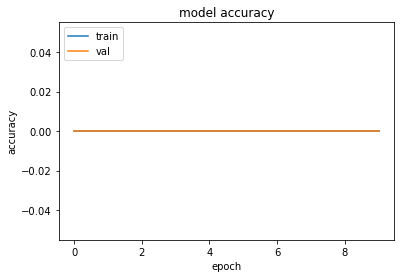

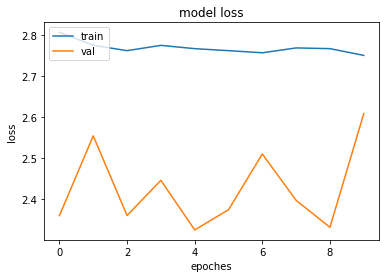

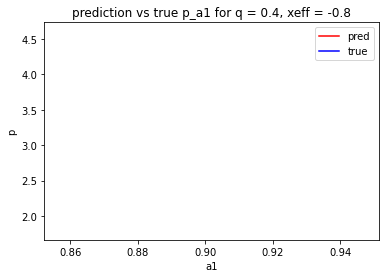

In [16]:
eva_model(model)